In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.sparse as sp

import os
import sys
sys.path.append('./')
# sys.path.append(os.path.realpath(__file__))

from embedding.bernoulli import Bernoulli

%matplotlib inline
sns.set_style('whitegrid')

In [8]:
from utils.graph_util import load_dataset

A, y = load_dataset()

In [16]:
from embedding.bernoulli import Bernoulli

b = Bernoulli()
emb = b.learn_embedding(A)

Epoch    0, loss = 1.02316
Epoch  250, loss = 0.01130
Epoch  500, loss = 0.00462
Epoch  750, loss = 0.00283
Epoch 1000, loss = 0.00210
Epoch 1250, loss = 0.00170
Epoch 1500, loss = 0.00145
Epoch 1750, loss = 0.00128
Epoch 2000, loss = 0.00116
Epoch 2250, loss = 0.00106
Epoch 2500, loss = 0.00099
Epoch 2750, loss = 0.00092
Epoch 3000, loss = 0.00086
Epoch 3250, loss = 0.00082
Epoch 3500, loss = 0.00077
Epoch 3750, loss = 0.00073
Epoch 4000, loss = 0.00070
Epoch 4250, loss = 0.00066
Epoch 4500, loss = 0.00064
Epoch 4750, loss = 0.00061


In [19]:
from sklearn.manifold import TSNE
# from umap import UMAP as TSNE

def visualize(emb, y):
#     emb = emb.cpu().detach().numpy()
    tsne = TSNE()
    vis = tsne.fit_transform(emb)
    plt.figure(figsize=[10, 8])
    plt.scatter(vis[:, 0], vis[:, 1], c=palette[y], s=20, alpha=0.8)
    
# Alternative to the default seaborn palette
palette = np.array(sns.color_palette('muted', n_colors=len(np.unique(y))))

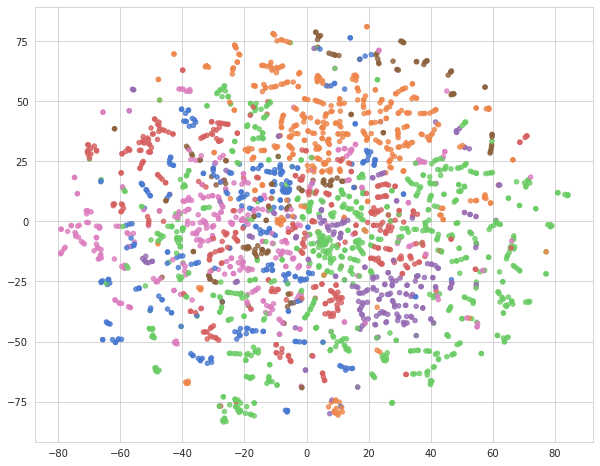

In [21]:
%matplotlib inline
visualize(emb, y)

In [ ]:
# '''
# Run the graph embedding methods on Karate graph and evaluate them on 
# graph reconstruction and visualization. Please copy the 
# gem/data/karate.edgelist to the working directory
# '''

# import matplotlib.pyplot as plt
# from time import time

# from gem.utils      import graph_util, plot_util
# from gem.evaluation import visualize_embedding as viz
# from gem.evaluation import evaluate_graph_reconstruction as gr

# from gem.embedding.gf       import GraphFactorization
# from gem.embedding.hope     import HOPE
# from gem.embedding.lap      import LaplacianEigenmaps
# from gem.embedding.lle      import LocallyLinearEmbedding
# from gem.embedding.node2vec import node2vec
# from gem.embedding.sdne     import SDNE
# from argparse import ArgumentParser


# if __name__ == '__main__':
#     ''' Sample usage
#     python run_karate.py -node2vec 1
#     '''
#     parser = ArgumentParser(description='Graph Embedding Experiments on Karate Graph')
#     parser.add_argument('-node2vec', '--node2vec',
#                         help='whether to run node2vec (default: False)')
#     args = vars(parser.parse_args())
#     try:
#         run_n2v = bool(int(args["node2vec"]))
#     except:
#         run_n2v = False

#     # File that contains the edges. Format: source target
#     # Optionally, you can add weights as third column: source target weight
#     edge_f = 'data/karate.edgelist'
#     # Specify whether the edges are directed
#     isDirected = True

#     # Load graph
#     G = graph_util.loadGraphFromEdgeListTxt(edge_f, directed=isDirected)
#     G = G.to_directed()

#     models = []
#     # Load the models you want to run
#     models.append(GraphFactorization(d=2, max_iter=50000, eta=1 * 10**-4, regu=1.0))
#     models.append(HOPE(d=4, beta=0.01))
#     models.append(LaplacianEigenmaps(d=2))
#     models.append(LocallyLinearEmbedding(d=2))
#     if run_n2v:
#         models.append(
#             node2vec(d=2, max_iter=1, walk_len=80, num_walks=10, con_size=10, ret_p=1, inout_p=1)
#         )
#     models.append(SDNE(d=2, beta=5, alpha=1e-5, nu1=1e-6, nu2=1e-6, K=3,n_units=[50, 15,], rho=0.3, n_iter=50, xeta=0.01,n_batch=100,
#                     modelfile=['enc_model.json', 'dec_model.json'],
#                     weightfile=['enc_weights.hdf5', 'dec_weights.hdf5']))

#     # For each model, learn the embedding and evaluate on graph reconstruction and visualization
#     for embedding in models:
#         print ('Num nodes: %d, num edges: %d' % (G.number_of_nodes(), G.number_of_edges()))
#         t1 = time()
#         # Learn embedding - accepts a networkx graph or file with edge list
#         Y, t = embedding.learn_embedding(graph=G, edge_f=None, is_weighted=True, no_python=True)
#         print (embedding._method_name+':\n\tTraining time: %f' % (time() - t1))
#         # Evaluate on graph reconstruction
#         MAP, prec_curv, err, err_baseline = gr.evaluateStaticGraphReconstruction(G, embedding, Y, None)
#         #---------------------------------------------------------------------------------
#         print(("\tMAP: {} \t preccision curve: {}\n\n\n\n"+'-'*100).format(MAP,prec_curv[:5]))
#         #---------------------------------------------------------------------------------
#         # Visualize
#         viz.plot_embedding2D(embedding.get_embedding(), di_graph=G, node_colors=None)
#         plt.show()
#         plt.clf()